**Ofir David**: [https://prove-me-wrong.com/](https://prove-me-wrong.com/)

**Contact**:	 [totallyRealField@gmail.com](mailto:totallyRealField@gmail.com)
<div style="width: 45%; margin: 0 auto; height: 10px; background-image: radial-gradient(circle, black 2px, transparent 2px); background-size: 15px 15px;"></div>
<h1 style="text-align:center;">Image stitching</h1>
<div style="width: 45%; margin: 0 auto; height: 15px; background-image: radial-gradient(circle, black 2px, transparent 2px); background-size: 15px 15px;"></div>

In this note we try to solve the following:

### Problem
> Given several pictures take from the same position, glue them together into a single "panoramic" shot.

The mathematics behind this problem can be [found here](points_of_view.md). Here I will just see an example in action. There is a more complicated version of this problem, where the pictures are taken from different positions, and instead of a panormaic view, we try to do **3D reconstruction** of the objects in the scene. I also wrote about this, and you can [find the notebook here](3d_reconstruction.ipynb).

# Python initialization

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import os
import importlib

np.set_printoptions(precision=2)

project_root = os.path.abspath("../..")  
if project_root not in sys.path:
    sys.path.append(project_root)
    
from vision import image_stitching
from vision import sift_compare
# in case I updated the code  
importlib.reload(sift_compare)    
importlib.reload(image_stitching)  

<module 'vision.image_stitching' from 'C:\\Users\\eofir\\PycharmProjects\\ai\\vision\\image_stitching.py'>

# Loading the images

We start by loading the images. You should note that while they were all taken from the same point, the orientations were very different from one another.

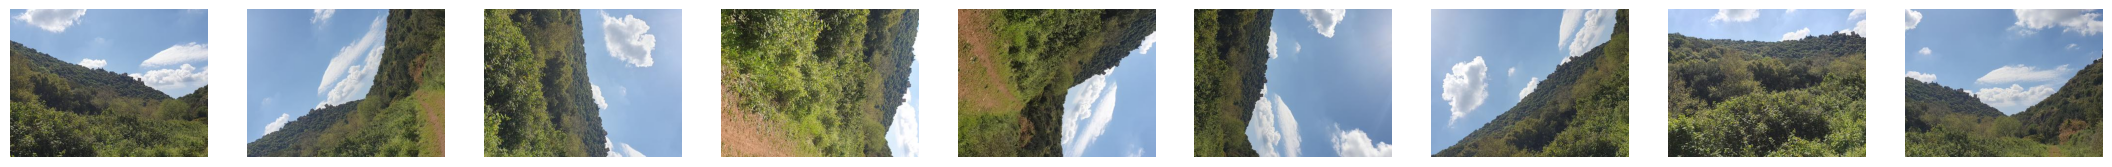

In [2]:
images = [
        cv2.imread(f'../images/monfort/{i}.jpg', cv2.IMREAD_COLOR_RGB) for i in [1,2,3,4,5,6,7,8,9]
]

if any(elem is None for elem in images):
    raise ValueError("Could not load one of the images.")

fig, axes = plt.subplots(1, len(images), figsize=(3*len(images),3))
for ax, img in zip(axes, images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

Our goal is eventually to stitch them all together to one image. The image seems a bit distorted, since they were taken in very wide range of angles, and the right way to view them is in a sort of 360 degrees views. However, this is only our first step, so we keep it as a 2D image.

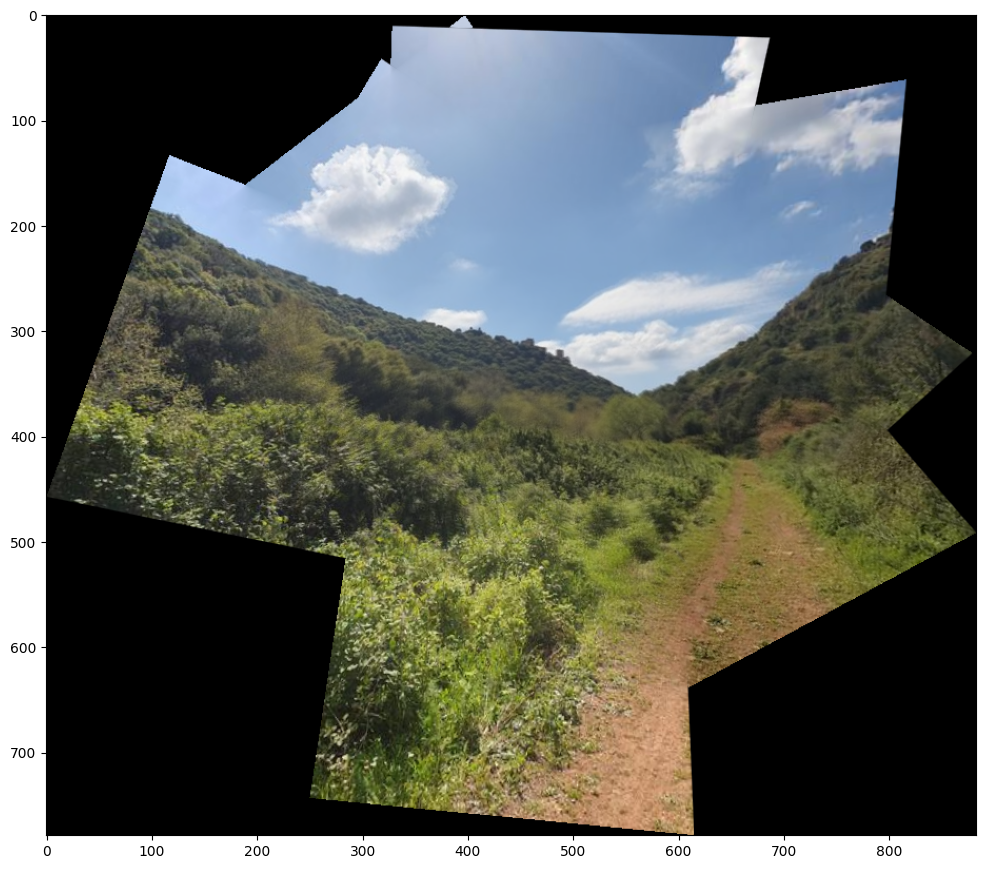

In [3]:
full_image = image_stitching.stitch_images(images)
plt.figure(figsize=(12,12))
plt.imshow(full_image, cmap='gray')
plt.show()

# Stitching images

Stitching images together seems very natural to us, as we do it constantly in our heads. However, teaching the computer how to do it is not as simple (though not too complicated either), and along the way contains all sort of interesting mathematics and algorithms. The main steps to solve this problem are:

1. Find some **good matching pairs** between pairs of images.
2. Use this matching to find a **geometric connection** between the images.
3. This connection will produce us a **projective map**, which once applied to one image, it will fit the second. Intuitively we should think of these maps as changing the orientation of the camera (though they contain more than that).
4. Finally, just gluing the images together will not be enough, and we will need to **smoothen the edges** between the different images.

OK, let's start!

## 1. Comparing images:

To stitch together two images, the first step is to find the keypoints which appear in both images. For example, we can use the SIFT algorithm to find the keypoints in each image separately, and then compare them.

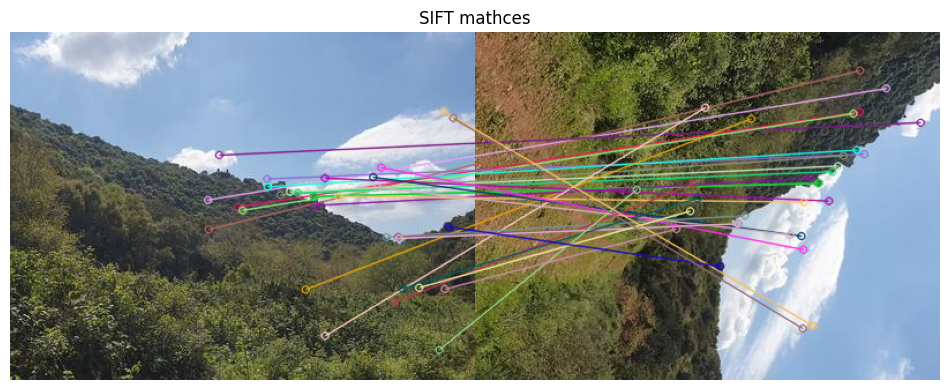

In [4]:
image_system = sift_compare.ImageSystem(images)

plt.figure(figsize=(12,6))
plt.imshow(image_system.matching_image(from_index=0,to_index=4, threshold=0.35))
plt.title('SIFT mathces')
plt.axis('off')
plt.show()


As we want to actually use these keypoints, and not just plot them:

In [5]:
matchings = image_system.matching(from_index=4, to_index=0, threshold=0.6)

## 2. Find image transformation:

The two images are viewed from two different angles. We want to transform the second image as though we see it from the orientation of the first camera. As mentioned before, the mathematics behind it can be [found here](points_of_view.md), the function implemented it is:

Projection map from right to left image:

[[-8.65e-04  1.21e-03  5.77e-01]
 [-1.34e-03 -1.23e-03  8.17e-01]
 [ 7.63e-07 -8.68e-07  1.69e-03]]


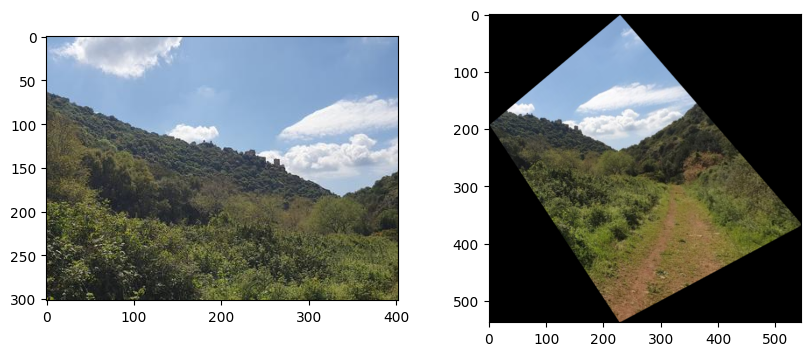

In [6]:
img0 = images[0]
img1 = images[4]

proj_from_1_to_0 = image_stitching.find_projective_transform(matchings)

print('Projection map from right to left image:\n')
print(proj_from_1_to_0)

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].imshow(img0)
axes[1].imshow(image_stitching.apply_proj(proj_from_1_to_0, img1)[0])
plt.show()

## 3. Combine the images - wraping the domains

The first problem when combining the images, is that they are represented as a rectangle of pixels. For example, the four corners of the second image are mapped to the following 4 points in the coordinate of the first image:

In [7]:
# The actual corners
from vision.image_stitching import Rect

domain1 = Rect.from_image(img1)
corners = domain1.corners(projective=True)
print('Original corners:')
print(corners[:2,:])

# The projected corners:
corners = proj_from_1_to_0 @ corners
corners = corners[:2] / corners[2:3]
corners = np.floor(corners).astype(int)

print('\nNew corners:')
print(corners)

Original corners:
[[  0 403 403   0]
 [  0   0 302 302]]

New corners:
[[341 114 342 660]
 [483 138 -54 313]]


The new image should be big enough to contain both images. Let's see where the second image should be glued to the first.
I use below the 'Rect(x,y,width,height)' class to define the domain of each image, and the domain of their union.

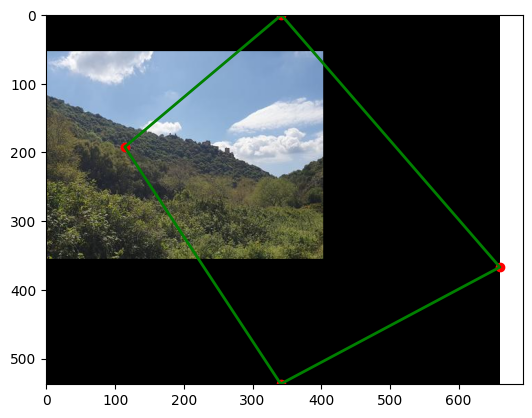

In [8]:

domain0 = Rect.from_image(img0)

domain = domain0.union(domain1.apply_proj(proj_from_1_to_0))

ext_img0 = image_stitching.change_domain(img0, domain0, domain)

plt.imshow(ext_img0, cmap='gray')

# add position of images[1]
rel_corners = corners - np.array([[domain.x],[domain.y]])
rel_corners = np.hstack([rel_corners, rel_corners[:,0:1]]) # repeat corner for a closed polygon
plt.plot(rel_corners[0], rel_corners[1], linestyle='-', color='green', linewidth=2)  
plt.scatter(rel_corners[0][:-1], rel_corners[1][:-1], color='red')  

plt.show()

## 4. Gluing images

If we just "glue" together the two images, we will get the following image:

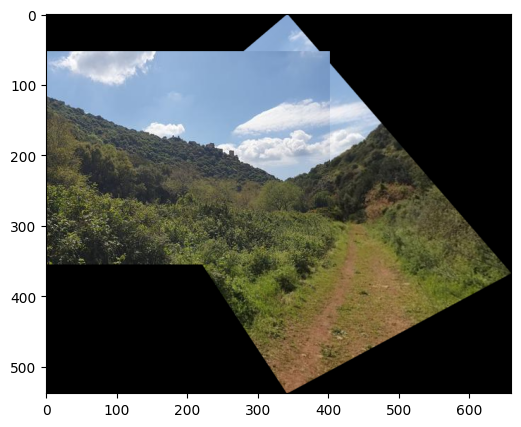

In [9]:
ext_img1, domain1 = image_stitching.apply_proj(proj_from_1_to_0, img1)
ext_img1 = image_stitching.change_domain(ext_img1, domain1, domain)

mask0 = np.ones(shape = img0.shape, dtype=img0.dtype)
ext_mask0 = image_stitching.change_domain(mask0, domain0, domain)

full_img = ext_img0 * ext_mask0 + ext_img1 * (1-ext_mask0)

plt.figure(figsize=(6,6))
plt.imshow(full_img)
plt.show()

While the gluing is in the right places, because the change in the light, we can see the boundaries of the pictures. In order to get rid of these, we add weights to each pixel in each image. The closer we are to the center of the image, the higher the weights are, and as we get closer to the boundary, the weights approach zero. Finally, we take the weighted average:
$$\frac{w_0 \cdot a_0 + w_1 \cdot a_1}{w_0+w_1}.$$

For example, we can use the simple weights on the unit square:
$$w(x,y)=x(1-x)y(1-y)$$
and extend it linearly to the image, to get the following weights:

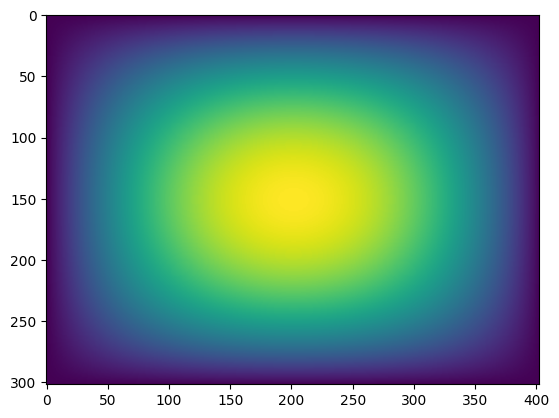

In [10]:
h1, w1 = img1.shape[:2]
rows = np.arange(0,1,1/h1)
cols = np.arange(0,1,1/w1)

row_weights = rows * (1 - rows)
col_weights = cols * (1 - cols)

weights1 = row_weights[:, np.newaxis] * col_weights[np.newaxis, :]

plt.imshow(weights1)
plt.show()

After the projection to the coordinates of the firest image we get:

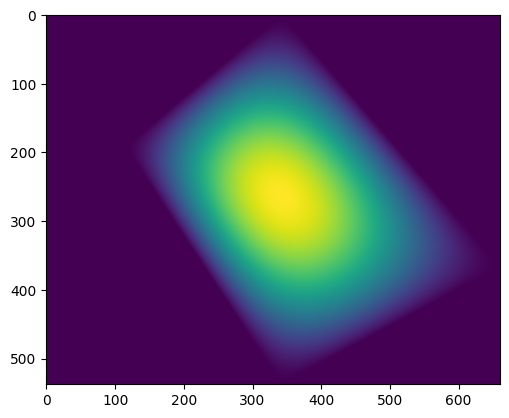

In [11]:
ext_weights1, domain1 = image_stitching.apply_proj(proj_from_1_to_0, weights1.astype(float))
ext_weights1 = image_stitching.change_domain(ext_weights1, domain1, domain)

plt.imshow(ext_weights1)
plt.show()

We can now combine everything together:

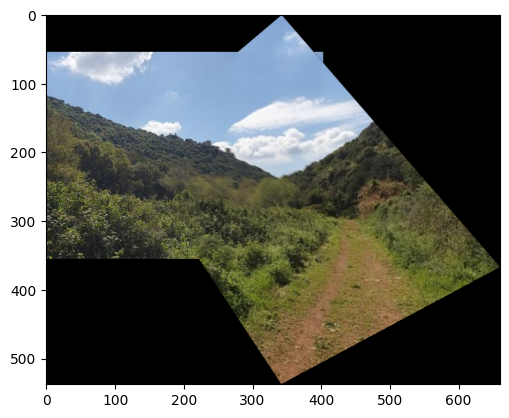

In [12]:
h0, w0 = img0.shape[:2]

rows = np.arange(0,1,1/h0)
cols = np.arange(0,1,1/w0)

row_weights = rows * (1 - rows)
col_weights = cols * (1 - cols)

weights0 = row_weights[:, np.newaxis] * col_weights[np.newaxis, :]
ext_weights0 = image_stitching.change_domain(weights0.astype(float), domain0, domain)

total_weights = ext_weights0 + ext_weights1
# We want to divide by the total weight, but we don't want to divide by zero...
total_weights[total_weights==0] = 1

full_image = (ext_weights0[:,:,np.newaxis]*ext_img0 + ext_weights1[:,:,np.newaxis]*ext_img1)/total_weights[:,:,np.newaxis]
full_image = np.round(full_image).astype(int)

plt.imshow(full_image)
plt.show()

---
# What is next ?

Here I have shown how to combine two images, and of course by induction we can combine many more of them. My code, as it is right now, just tried to glue all the images to a single image. Once I have some time, I will change it so it will try to glue it to some image which appeared before. Another interesting feature is to view the picture in a 360 degrees instead of a single big flat picture.

Of course, the really big next step is the harder version of this problem where the images are taken from different positions and we try to do [**3D reconstruction**](3d_reconstruction.ipynb), which I have already done a lot of it in recent weeks.

Have any other ideas? I would love to hear them.

---
**Ofir David**: [https://prove-me-wrong.com/](https://prove-me-wrong.com/)

**Contact**:	 [totallyRealField@gmail.com](mailto:totallyRealField@gmail.com)